In [1]:
from lib.opt_types import *
from lib.utils import *
from lib.part_one import f, f_full_data, x_zero

# Stochastic gradient methods - 30 Points


In this problem, you will implement three different versions of stochastic gradient descent to solve the logistic regression problem on the entire NBA dataset.

In order to use the stochastic gradient descent methods, we recast our estimation problem [3](#mjx-eqn-eq3) as follows,

\begin{equation}
\tag{6}
f(\mathbf{x}) = \frac{1}{n}\sum_{i=1}^n\bigg\{\underbrace{\log(1 + \exp(- b_i \mathbf{a}_i^T\mathbf{x})) + \frac{\mu}{2}\|\mathbf{x}\|^2}_{f_i(\mathbf{x})}\bigg\},
\end{equation}

where we for notational convenience suppress the dependency on $\mu$.
As we saw in Problem 1, we have that

\begin{equation}
\nabla f_i(\mathbf{x}) = -b_i \sigma(-b_i \cdot \mathbf{a}_i^T\mathbf{x})\mathbf{a}_i + \mu \mathbf{x}.
\end{equation}

The objective function can be written as a sum of $n$ terms. We augment the `Function` type introduced in previous notebooks to include the following attributes:

- To access the gradient of the `j`-th term at a point `x` you can write `f.i_grad(j, x)`.
- The number of terms $n$ is stored in the attribute `f.n`. 

Consider the following stochastic gradient update: At the iteration $k$, pick $i_k\in\{1, \ldots, n\}$ uniformly at random and define

\begin{equation}
\mathbf{x}^{k+1} :=  \mathbf{x}^k - \alpha_k\nabla{f}_{i_k}(\mathbf{x}^k).\tag{SGD}
\end{equation}

__(a)__ (2 points) Show that $\nabla f_{i_k}(\mathbf{x})$ is an unbiased estimation of $\nabla f(\mathbf{x})$. Explain why $\nabla f_{i_k}$ is Lipschitz continuous with $L(f_{i_k}) = \|\mathbf{a}_{i_k}\|^2+ \mu $. 

__Hint__: Recall how we computed $L$ in Problem 1. In the following, we will set $L_{\max} = \max_{i\in\{1, \ldots, n\}}L(f_i)$.

**Solution**

1. 

\begin{equation}
\mathbb{E} \left[ \nabla f_{i_k}(x) \right] = \sum_{i_k=1}^{m} p \left( \nabla f_{i_k}(x) \right) \nabla f_{i_k}(x)
= \sum_{i_k=1}^{m} \frac{1}{n} \nabla f_{i_k}(x)
= \frac{1}{n} \sum_{i_k=1}^{m} \nabla f_{i_k}(x) = \nabla f(x)
\end{equation}

2. 
From part (1) we prove that  $f_{\mu}$ is $ L $-smooth for $ L = \|A\|_F^2 + \mu $.

Hence $ f_{i_k} $ is $L $-smooth for $ L = \|a_i^T\|^2 + \mu = \|a_i\|^2 + \mu $.


__(b)__ (2 points) 
We can use the standard stochastic gradient descent method [SGD](#mjx-eqn-eqSGD) to solve [6](#mjx-eqn-eq6). 
Implement `SGD` by completing the following cells with $\alpha_k =\frac{0.01}{k}$.

**Hint**: For some `N`, the function `np.random.choice(N)` generates a random integer in $\{0, \dots, N-1 \}$.


In [2]:
@dataclass
class SGD_state(OptState):
    x_k: Vector
    k: int

In [3]:
def SGD_update(f, state):
    x_k, k = state

    i_k = np.random.choice(f.n)
    alpha_k = 0.01/k

    next_x_k = x_k - alpha_k * f.i_grad(i_k, x_k)

    return SGD_state(next_x_k, k+1)

def SGD_initialize(f, x_zero):
    return SGD_state(x_zero, 1.0)

In [4]:
SGD = OptAlgorithm(name="SGD", init_state=SGD_initialize, state_update=SGD_update)

__(c)__ (6 points) 
Consider the following stochastic averaging gradient method [SAG](#mjx-eqn-eqSAG) to solve [6](#mjx-eqn-eq6):
\begin{equation}
\begin{cases}
\text{pick } i_k\in\{1, \ldots, n\} \text{ uniformly at random}\\
\mathbf{x}^{k+1} := \mathbf{x}^k - \frac{\alpha_k}{n}\sum_{i=1}^n\mathbf{v}_i^k,
\end{cases}
\end{equation}
where 
\begin{equation}
\mathbf{v}_i^k =
\begin{cases}
\nabla f_i(\mathbf{x}^k) &\text{if}\, i = i_k,\\
\mathbf{v}_i^{k-1} &\text{otherwise}.
\end{cases}
\end{equation}

Implement `SAG` by completing the following cells using the step-size 
$\alpha_k=\frac{0.01}{L_{\max}}$ and $\mathbf{v}^0=\mathbf{0}$. (Note that you can access $L_{\max}$ by writing `f.L_max`.

In [5]:
@dataclass
class SAG_state(OptState):
    x_k: Vector
    v_k: List[Vector]
    alpha_k: float
    sum_v_k: Vector

In [6]:
def SAG_update(f, state):
    x_k, v_k, alpha_k, sum_v_k = state.x_k, state.v_k, state.alpha_k, state.sum_v_k

    i_k = np.random.choice(f.n)
    ith_grad = f.i_grad(i_k, x_k)
    sum_v_k = sum_v_k - v_k[i_k] + ith_grad

    v_k[i_k] = ith_grad
    next_x_k = x_k - alpha_k/f.n * sum_v_k
    return SAG_state(next_x_k, v_k, alpha_k, sum_v_k= sum_v_k)

def SAG_initialize(f, x_zero):
    return SAG_state(x_k=x_zero, v_k = np.zeros((f.n, len(x_zero))), alpha_k=0.01/f.L_max, sum_v_k=np.zeros(len(x_zero)))

In [7]:
SAG = OptAlgorithm(name="SAG", init_state=SAG_initialize, state_update=SAG_update)

SGD    :   0%|          | 0/500000 [00:00<?, ?it/s]

SAG    : 100%|██████████| 500000/500000 [00:19<00:00, 25373.05it/s]


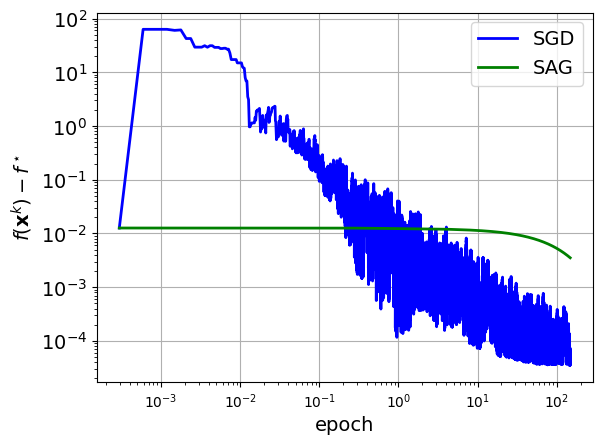

In [8]:
plot_epochs([SGD, SAG], f, x_zero, 500000)

__(d)__ (6 points) 
We can improve the convergence rate of SGD by periodically computing the full gradient. `SVRG` uses the following variance reduction scheme:
\begin{equation}
\begin{cases}
\text{if } k = 0 \text{ mod } q:\\
\quad \mathbf{z} = \mathbf{x}^k\\
\quad \tilde{\mathbf{v}} = \nabla f(\mathbf{x}^k)\\
\text{Pick } i_k\in \{1, \ldots, n\} \text{ uniformly at random}\\
\mathbf{d}^k = \nabla f_{i_k}({\mathbf{x}}^k) - \nabla f_{i_k}(\mathbf{z}) + \tilde{\mathbf{v}}\\
{\mathbf{x}}^{k+1} := {\mathbf{x}}^k - \gamma\mathbf{d}^k\\
\end{cases}
\end{equation}

Implement `SVRG` by completing the following cells and fixing the following constant:
$\gamma = 1/L_{\max}$ and $q = 100$.

In [9]:
@dataclass
class SVRG_state(OptState):
    x_k: Vector 
    z: Vector
    tilde_v: Vector
    q: int
    gamma: float
    k: int

In [10]:
def SVRG_update(f, state):
    x_k, z, tilde_v, q, gamma, k = state

    if k % q == 0:
        z = x_k
        tilde_v = f.grad(z)

    i_k = np.random.choice(f.n)
    d_k = f.i_grad(i_k, x_k) - f.i_grad(i_k, z) + tilde_v

    next_x_k = x_k - gamma * d_k

    return SVRG_state(next_x_k, z, tilde_v, q, gamma, k+1)

def SVRG_initialize(f, x_zero):
    gamma = 1 / f.L_max
    q = 100
    tilde_v = np.zeros(len(x_zero)) # initialized at first iteration as k = 0
    return SVRG_state(x_k=x_zero, z=x_zero, tilde_v=tilde_v, q=q, gamma=gamma, k=0)

In [11]:
SVRG = OptAlgorithm(name="SVRG", init_state=SVRG_initialize, state_update=SVRG_update)

__(e)__ (8 points) Another variance reduction method is `SARAH`. The scheme can be described as follows:

\begin{equation}
\begin{cases}
\text{if } k = 0 \text{ mod } q:\\
\quad {\mathbf{x}}^k = {\mathbf{z}}\\
\quad {\mathbf{v}}^k = \nabla f({\mathbf{z}})\\
\quad t \in \{0, \ldots, q-1\} \text{ uniformly at random}\\
\text{if } k = t \text{ mod } q:\\
\quad {\mathbf{z}} = {\mathbf{x}}^{k}\\
\text{Pick } i_k\in \{1, \ldots, n\} \text{ uniformly at random}\\
{\mathbf{v}}^{k+1} = \nabla f_{i_k}({\mathbf{x}}^k) - \nabla f_{i_k}({\mathbf{x}^{k-1}}) + {\mathbf{v}}^{k}\\
{\mathbf{x}}^{k+1} := {\mathbf{x}}^k - \gamma {\mathbf{v}}^{k+1}\\
\end{cases}
\end{equation}


Implement `SARAH` by completing the following cells. Pick `q=100` and $\gamma = \frac{1}{L_{\max}}$.

In [12]:
@dataclass
class SARAH_state(OptState):
    x_k: Vector 
    prev_x_k: Vector
    v_k: Vector
    z: Vector
    q: int
    t: int
    gamma: float
    k: int

In [13]:
def SARAH_update(f, state):
    x_k, prev_x_k, v_k, z, q, t, gamma, k = state

    if k % q == 0:
        x_k = z
        v_k = f.grad(z)
        t = np.random.choice(q)

    if k % q == t:
        z = x_k
        
    i_k = np.random.choice(f.n)
    next_v_k = f.i_grad(i_k, x_k) - f.i_grad(i_k, prev_x_k) + v_k 
    next_x_k = x_k - gamma * next_v_k

    return SARAH_state(next_x_k, x_k, next_v_k, z, q, t, gamma, k+1)

def SARAH_initialize(f, x_zero):
    gamma = 1 / f.L_max
    q = 100
    v_k = np.zeros(len(x_zero)) # initialized at first iteration as k = 0
    return SARAH_state(x_k=x_zero, prev_x_k=x_zero, v_k=v_k, z=x_zero, q=q, t=0, gamma=gamma, k=0)

In [14]:
SARAH = OptAlgorithm(name="SARAH", init_state=SARAH_initialize, state_update=SARAH_update)

__(f)__ (6 points) Another variance reduction method is `Spider`. The scheme can be described as follows:

\begin{equation}
\begin{cases}
\text{if } k = 0 \text{ mod } q:\\
\quad {\mathbf{v}}^k = \nabla f({\mathbf{x}}^k)\\
\text{if } k \neq 0 \text{ mod } q:\\
\quad \text{Pick } i_k\in \{1, \ldots, n\} \text{ uniformly at random}\\
\quad {\mathbf{v}}^k = \nabla f_{i_k}({\mathbf{x}}^k) - \nabla f_{i_k}({\mathbf{x}}^{k-1}) + {\mathbf{v}}^{k-1}\\
\eta := \min \big(\frac{1}{\left \| {\mathbf{v}}^{k} \right \|_2}, \frac{1}{\epsilon}\big)\\
{\mathbf{x}}^{k+1} := {\mathbf{x}}^k - \gamma \eta {\mathbf{v}}^{k}\\
\end{cases}
\end{equation}


Implement `Spider` by completing the following cells. Pick `q=100`, $\epsilon = 0.05$ and $\gamma = \frac{1}{L_{\max}}$.

In [15]:
@dataclass
class Spider_state(OptState):
    x_k: Vector 
    prev_x_k: Vector
    prev_v_k: Vector
    q: int
    gamma: float
    k: int
    epsilon: float

In [16]:
import numpy
from numpy.linalg import norm

def Spider_update(f, state):
    x_k, prev_x_k, prev_v_k, q, gamma, k, epsilon = state

    if k % q == 0:
        v_k = f.grad(x_k)

    if k % q != 0: # else
        i_k = np.random.choice(f.n)
        v_k = f.i_grad(i_k, x_k) - f.i_grad(i_k, prev_x_k) + prev_v_k
        
    eta = min(1 / norm(v_k), 1 / epsilon)
    next_x_k = x_k - gamma * eta * v_k
    return Spider_state(next_x_k, x_k, v_k, q, gamma, k+1, epsilon)
    

def Spider_initialize(f, x_zero):
    gamma = 1 / f.L_max
    q = 100
    epsilon = 0.05
    prev_v_k = np.zeros(len(x_zero)) # initialized at first iteration as k = 0
    return Spider_state(x_k=x_zero, prev_x_k=x_zero, prev_v_k=prev_v_k, q=q, gamma=gamma, k=0, epsilon=epsilon)

In [17]:
Spider = OptAlgorithm(name="Spider", init_state=Spider_initialize, state_update=Spider_update)

Spider : 100%|██████████| 50000/50000 [00:35<00:00, 1404.58it/s]


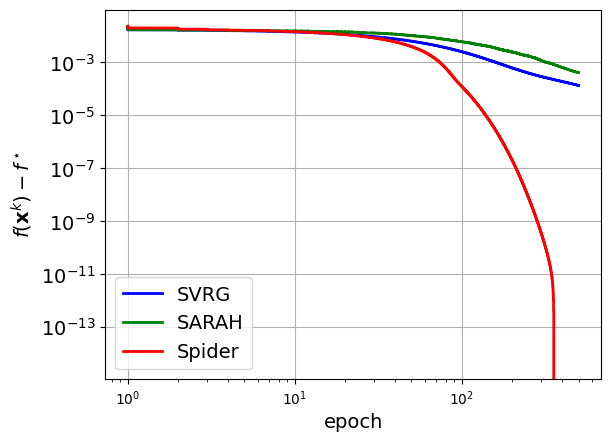

In [18]:
plot_epochs([SVRG, SARAH, Spider], f_full_data, x_zero, 50000)